In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Paths to images and masks directories
image_dir = r"D:\Neeraj\SEM 7\DLE LAB\Banana FCN\Banana FCN\Images"
mask_dir = r"D:\Neeraj\SEM 7\DLE LAB\Banana FCN\Banana FCN\Mask"

# Image and mask data generators
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    color_mode='rgb',
    target_size=(128, 128),
    batch_size=8,
    seed=42
)

Found 82 images belonging to 1 classes.


In [34]:
mask_generator = mask_datagen.flow_from_directory(
    mask_dir,
    class_mode=None,
    color_mode='grayscale',
    target_size=(128, 128),
    batch_size=8,
    seed=42
)

Found 82 images belonging to 1 classes.


In [36]:
# Combine generators into one which yields image and mask
train_generator = zip(image_generator, mask_generator)

In [38]:
def build_fcnn():
    inputs = Input((128, 128, 3))

    # Encoder
    conv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(up2)

    model = Model(inputs, outputs)
    return model

model = build_fcnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 1)         │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,200,513 (4.58 MB)

 Trainable params: 1,200,513 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the FCNN model
def combined_generator(image_gen, mask_gen):
    while True:  # Keep yielding data indefinitely
        img_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield img_batch, mask_batch  # Keras expects (input, target)
# Fit the model with the custom generator
train_generator = combined_generator(image_generator, mask_generator)
model.fit(train_generator, steps_per_epoch=len(image_generator), epochs=5)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 742ms/step - accuracy: 0.6078 - loss: 0.6460
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 744ms/step - accuracy: 0.6892 - loss: 0.5565
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 719ms/step - accuracy: 0.6816 - loss: 0.5444
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 797ms/step - accuracy: 0.6812 - loss: 0.5336
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 718ms/step - accuracy: 0.6165 - loss: 0.5213


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


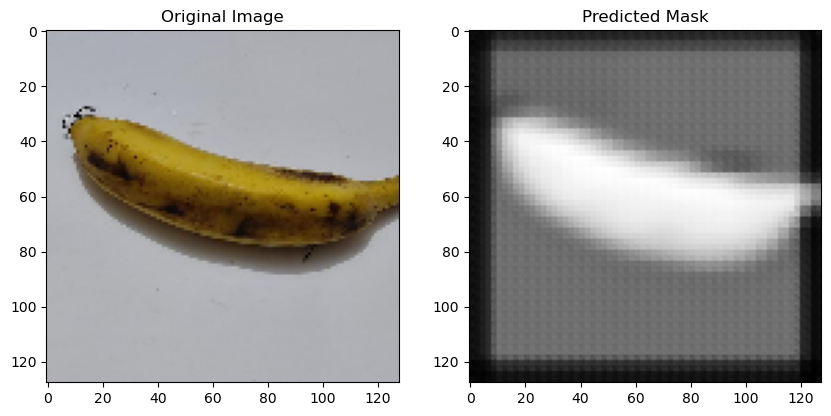

In [41]:
# Sample image for prediction
sample_image = image_generator[0][0]
predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]

# Display the original image and predicted mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(sample_image)

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')

plt.show()